In [80]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV


# show all columns when displaying a data frame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1.0 Data Preeprocessing

In [55]:
dtypes = {'country':'category', 'cat_name':'category', 'cat_slug':'category', 'loc_name':'category', 
'loc_country':'category', 'loc_state':'category', 'loc_type':'category', 'main_category':'category', 
'sub_category':'category', 'goal_categorical':'category', 'currency':'category', 'usd_type':'category'}
frame_all = pd.read_csv('data/Kickstarter_full.csv', index_col=0, parse_dates=['created_at', 'launched_at', 'deadline', 'state_changed_at'], dtype=dtypes)

In [56]:
columns = frame_all.columns

In [57]:
columns

Index(['backers_count', 'blurb', 'converted_pledged_amount', 'country',
       'created_at', 'currency', 'currency_symbol', 'currency_trailing_code',
       'current_currency', 'deadline', 'disable_communication', 'fx_rate',
       'goal', 'id', 'is_starrable', 'launched_at', 'name', 'pledged', 'slug',
       'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at',
       'static_usd_rate', 'usd_pledged', 'usd_type', 'dur_inactive',
       'dur_until_state_changed', 'dur_active', 'dur_ratio', 'cat_name',
       'cat_slug', 'loc_name', 'loc_country', 'loc_state', 'loc_type',
       'photo_thumb', 'photo_large', 'project_address', 'profile_photo',
       'creator_name', 'creator_id', 'creator_thumb', 'creator_address',
       'main_category', 'sub_category', 'goal_surpass', 'goal_surpass_share',
       'goal_surpass_usd', 'goal_usd', 'goal_categorical', 'blurb_words',
       'blurb_len', 'name_len', 'name_words', 'state_bool', 'baseline'],
      dtype='object')

In [58]:
to_delete = ['backers_count',
 'blurb',
 'created_at',
 'converted_pledged_amount',
 'currency_symbol',
 'currency_trailing_code',
 'current_currency',
 'deadline',
 'goal',
 'id',
 'is_starrable',
 'launched_at',
 'name',
 'pledged',
 'slug',
 'source_url',
 'spotlight',
 'staff_pick',
 'state',
 'state_changed_at',
 'usd_pledged',
 'cat_name',
 'cat_slug',
 'loc_name',
 'loc_country',
 'loc_state',
 'photo_thumb',
 'photo_large',
 'project_address',
 'profile_photo',
 'creator_name',
 'creator_id',
 'creator_thumb',
 'creator_address',
 'goal_surpass',
 'goal_surpass_share',
 'goal_surpass_usd',
 'baseline',
 'disable_communication',
 'goal_usd',
 'dur_until_state_changed',
 'dur_ratio',
 'fx_rate',
 'static_usd_rate',
 'blurb_words',
 'name_words'
 ]

# Additionally deleted: 
# Cannot be known a priori: 'dur_until_state_changed', 'dur_ratio'
# Somehow a duplicate: 'goal_usd', 'blurb_words', 'name_words'
# For other reasons: 'fx_rate', 'static_usd_rate'

In [59]:
frame_all.drop(columns=to_delete, inplace=True)

In [60]:
# Save category-column-names in list
categorical_cols = frame_all.select_dtypes(include='category').columns

# Create dummies
frame_all = pd.get_dummies(frame_all, columns = categorical_cols, drop_first=True)

In [61]:
# save numerical features in a list
num_features = frame_all.select_dtypes(include='number').columns.to_list()
num_features.remove('state_bool')

In [62]:
X = frame_all.drop('state_bool', axis=1)
y = frame_all.state_bool

In [63]:
RSEED=42
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RSEED)

## Scaling

In [64]:
# scale the (few) numerical features
std = StandardScaler()
X_train_scaled = X_train.copy(deep=True)
X_test_scaled = X_test.copy(deep=True)
X_train_scaled[num_features] = std.fit_transform(X_train_scaled[num_features])
X_test_scaled[num_features] = std.transform(X_test_scaled[num_features])

# 2.0 XGBoost Model - Silvester Stallone

In [65]:
# Fit model to training data

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

model.fit(X_train_scaled,y_train)

# Make predictions on test set 
y_pred = model.predict(X_test_scaled)

In [66]:
# Training predictions (to demonstrate overfitting)
train_predictions = model.predict(X_train_scaled)
train_probs = model.predict_proba(X_train_scaled)[:, 1]

# Testing predictions (to determine performance)
predictions = model.predict(X_test_scaled)
probs = model.predict_proba(X_test_scaled)[:, 1]

In [67]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve


# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

# Function for calculating the evaluation metrics and plotting the ROC-curve
# TODO: CHANGE BASELINE MODEL TO OURS?

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, 
                                     [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, 
                                      [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 10
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();


In [68]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Function to plot the confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 15)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 10,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)


In [69]:
y_train.value_counts()

1    70913
0    55594
Name: state_bool, dtype: int64

## 2.1 Evaluation of the simple XGBoost model

Recall Baseline: 1.0 Test: 0.82 Train: 0.83
Precision Baseline: 0.56 Test: 0.81 Train: 0.82
Roc Baseline: 0.5 Test: 0.88 Train: 0.89


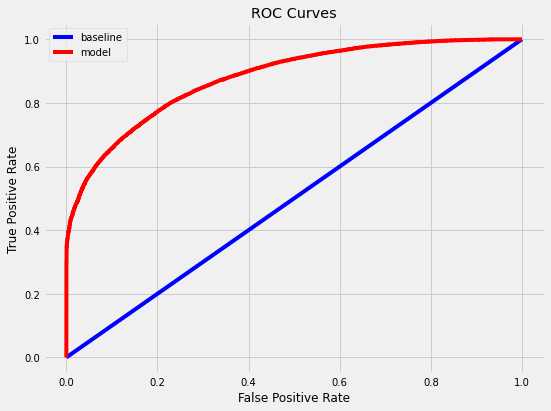

In [70]:
evaluate_model(predictions, probs, train_predictions, train_probs)
# plt.savefig('image/nb1_roc_auc_curve.png')

Confusion matrix, without normalization
[[13922  4610]
 [ 4368 19270]]
Confusion matrix, without normalization
[[42552 13042]
 [12211 58702]]


/var/folders/_2/0mbl5gkd02l3mjd7fnqkpl1c0000gn/T/ipykernel_53352/2516166632.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(aspect=4)
/var/folders/_2/0mbl5gkd02l3mjd7fnqkpl1c0000gn/T/ipykernel_53352/2516166632.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(aspect=4)


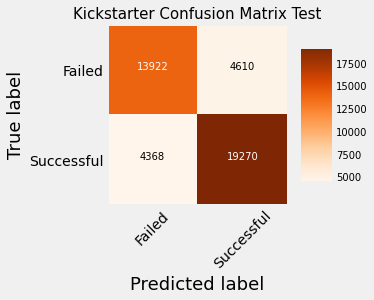

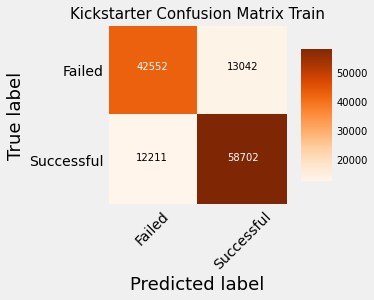

In [71]:
# Execute confusion matrices

# Confusion matrix TEST
cm_test = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm_test, classes = ['Failed','Successful'],
                      title = 'Kickstarter Confusion Matrix Test')

# Confusion matrix TRAIN
cm_train = confusion_matrix(y_train, train_predictions)
plot_confusion_matrix(cm_train, classes = ['Failed','Successful'],
                      title = 'Kickstarter Confusion Matrix Train')

# plt.savefig('image/nb1_cm.png')

In [72]:
# Execute classification matrices

cr_train = classification_report(y_train, train_predictions)
print('Classification on train data')
print(cr_train)

cr_test = classification_report(y_test, predictions)
print('Classification on test data')
print(cr_test)


Classification on train data
              precision    recall  f1-score   support

           0       0.78      0.77      0.77     55594
           1       0.82      0.83      0.82     70913

    accuracy                           0.80    126507
   macro avg       0.80      0.80      0.80    126507
weighted avg       0.80      0.80      0.80    126507

Classification on test data
              precision    recall  f1-score   support

           0       0.76      0.75      0.76     18532
           1       0.81      0.82      0.81     23638

    accuracy                           0.79     42170
   macro avg       0.78      0.78      0.78     42170
weighted avg       0.79      0.79      0.79     42170



In [73]:
# Features for feature importances
features = list(X_train_scaled.columns)

In [74]:
# Check feature importances

fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

print("Top15 Features sorted by importance")
print(fi_model.head(15))

Top15 Features sorted by importance
                           feature  importance
52              main_category_food    0.047638
58        main_category_technology    0.030352
138      sub_category_mobile games    0.027061
123        sub_category_indie rock    0.025835
172              sub_category_rock    0.025073
88     sub_category_country & folk    0.022390
78   sub_category_children's books    0.022090
176            sub_category_shorts    0.021781
94        sub_category_documentary    0.021497
144        sub_category_nonfiction    0.021123
84        sub_category_comic books    0.021097
108           sub_category_fiction    0.020798
193       sub_category_video games    0.020681
121      sub_category_illustration    0.020195
142    sub_category_narrative film    0.019362


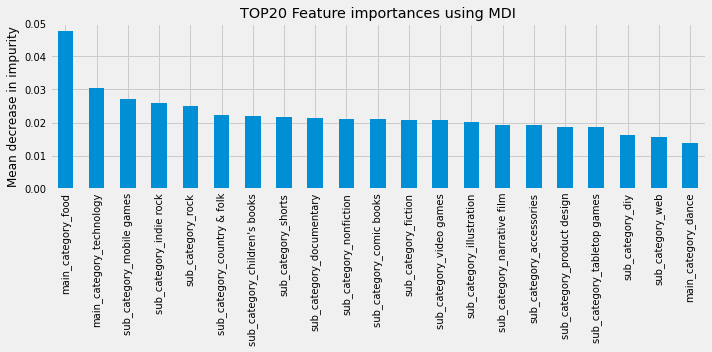

In [75]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
importances = model.feature_importances_
# std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

# forest_importances_test = pd.Series(importances, index=feature_names)

forest_importances_imp = pd.Series(importances, index=features)
forest_importances_imp_top20 = forest_importances_imp.sort_values(ascending=False).iloc[0:21]

fig, ax = plt.subplots(figsize=(10, 5))
forest_importances_imp_top20.plot.bar(ax=ax)
ax.set_title("TOP20 Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

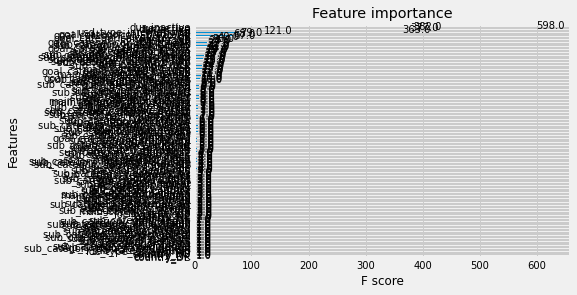

In [95]:
from xgboost import plot_importance

# plot feature importance with in-built method of XGBoost:
plot_importance(model)
plt.show()

## 2.4 Prediction of stakeholder project

https://www.kickstarter.com/projects/displayjoefigures/series-1-display-cases/description

In [85]:
# load data of stakeholder project

x_test_real = pd.read_csv('data/20220404_x_test_real_new.csv', sep=";", index_col=0)

In [86]:
x_test_real

,dur_inactive,name_len,dur_active,blurb_len,usd_type_international,main_category_food,goal_categorical_1_to_500,goal_categorical_500_to_5k,main_category_technology,sub_category_documentary,sub_category_shorts,sub_category_video games,sub_category_mobile games,sub_category_web,sub_category_nonfiction,sub_category_illustration,loc_type_Town,sub_category_indie rock,sub_category_fiction,goal_categorical_5k_to_10k,sub_category_country & folk,goal_categorical_10k_to_25k,sub_category_narrative film,sub_category_children's books,sub_category_rock,sub_category_product design,goal_categorical_25k_to_50k,goal_categorical_50k_to_100k,sub_category_tabletop games,main_category_music,sub_category_comic books,currency_USD,country_US,goal_categorical_200k_to_1m,main_category_publishing,main_category_film & video,main_category_comics,main_category_dance,currency_EUR,sub_category_hip-hop,main_category_games,country_GB,currency_GBP,main_category_crafts,loc_type_Suburb,sub_category_webseries,sub_category_software,main_category_photography,main_category_journalism,main_category_theater,sub_category_apparel,main_category_fashion,sub_category_accessories,main_category_design,sub_category_animation,currency_CAD,country_CA,sub_category_apps,sub_category_electronic music,sub_category_diy,country_AU,sub_category_public art,sub_category_mixed media,sub_category_comedy,sub_category_digital art,sub_category_classical music,sub_category_performance art,sub_category_jewelry,sub_category_food trucks,sub_category_sculpture,sub_category_painting,sub_category_academic,sub_category_world music,sub_category_pop,sub_category_television,sub_category_live games,sub_category_ready-to-wear,sub_category_art books,sub_category_drama,sub_category_young adult,sub_category_graphic design,sub_category_hardware,sub_category_woodworking,sub_category_people,sub_category_poetry,sub_category_drinks,sub_category_playing cards,country_IT,sub_category_conceptual art,country_DE,sub_category_horror,sub_category_events,sub_category_action,sub_category_photobooks,sub_category_places,sub_category_restaurants,sub_category_jazz,country_FR,sub_category_graphic novels,sub_category_radio & podcasts,sub_category_faith,sub_category_experimental,sub_category_gadgets,country_MX,currency_MXN,sub_category_nature,sub_category_plays,sub_category_periodicals,sub_category_candles,country_NL,sub_category_spaces,sub_category_anthologies,sub_category_thrillers,sub_category_music videos,country_ES,sub_category_childrenswear,sub_category_festivals,sub_category_r&b,sub_category_small batch,sub_category_musical,sub_category_wearables,sub_category_footwear,sub_category_metal,sub_category_science fiction,loc_type_LocalAdmin,country_SE,sub_category_fine art,sub_category_webcomics,sub_category_diy electronics,sub_category_installations,sub_category_print,currency_SEK,sub_category_architecture,sub_category_video,sub_category_farms,sub_category_family,sub_category_performances,sub_category_textiles,sub_category_interactive design,sub_category_farmer's markets,sub_category_sound,sub_category_ceramics,sub_category_calendars,sub_category_robots,sub_category_3d printing,sub_category_audio,sub_category_gaming hardware,sub_category_zines,sub_category_fantasy,country_DK,sub_category_workshops,currency_DKK,country_NZ,currency_NZD,sub_category_animals,sub_category_crochet,goal_categorical_1m_to_5m,sub_category_stationery,country_IE,sub_category_vegan,sub_category_flight,sub_category_camera equipment,sub_category_immersive,sub_category_movie theaters,sub_category_couture,sub_category_cookbooks,loc_type_Zip,sub_category_punk,sub_category_literary journals,sub_category_blues,sub_category_kids,sub_category_civic design,sub_category_puzzles,sub_category_printing,country_HK,sub_category_glass,currency_HKD,country_BE,sub_category_knitting,country_NO,sub_category_space exploration,sub_category_video art,sub_category_latin,currency_CHF,currency_NOK,country_CH,country_SG,sub_category_translations,currency_SGD,sub_category_photo,sub_ca

In [89]:
# Scale the new data:
x_test_real_scaled = std.transform(x_test_real)

/Users/c_messerschmidt/Documents/neuefische/kick_it_like_beckham/.venv/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [92]:
# Predict success or failure of stakeholder project
case_predictions = model.predict(x_test_real_scaled)
case_probs = model.predict_proba(x_test_real_scaled)[:, 1]

In [94]:
print("RESULT:")
print(f"The project campaign of the stakeholder is estimated to be {case_predictions} (0= Fail, 1=Success).")
print(f"The estimated prpbability for the result is {case_probs}.")

RESULT:
The project campaign of the stakeholder is estimated to be [1] (0= Fail, 1=Success).
The estimated prpbability for the result is [0.66901374].


# 3.0 Randomized Grid Search

In [96]:
param_grid = {
    'n_estimators': [100, 400],
    'colsample_bytree': [0.2, 0.7, 0.8],
    'max_depth': [15,20,25,30],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.7, 0.8, 0.9],
    # 'booster': ['gbtree', 'dart'], 

}

In [84]:
rand_grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='accuracy', verbose=4, cv=5, n_jobs=4)
best_model_r = rand_grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 3/5] END colsample_bytree=0.2, max_depth=20, n_estimators=100, reg_alpha=1.3, reg_lambda=1.1, subsample=0.9;, score=0.782 total time= 1.8min
[CV 1/5] END colsample_bytree=0.2, max_depth=20, n_estimators=100, reg_alpha=1.3, reg_lambda=1.1, subsample=0.9;, score=0.783 total time= 1.9min
[CV 2/5] END colsample_bytree=0.2, max_depth=20, n_estimators=100, reg_alpha=1.3, reg_lambda=1.1, subsample=0.9;, score=0.785 total time= 1.9min
[CV 4/5] END colsample_bytree=0.2, max_depth=20, n_estimators=100, reg_alpha=1.3, reg_lambda=1.1, subsample=0.9;, score=0.783 total time= 1.9min
[CV 5/5] END colsample_bytree=0.2, max_depth=20, n_estimators=100, reg_alpha=1.3, reg_lambda=1.1, subsample=0.9;, score=0.784 total time= 2.5min
[CV 3/5] END colsample_bytree=0.2, max_depth=15, n_estimators=700, reg_alpha=1.3, reg_lambda=1.1, subsample=0.8;, score=0.775 total time=11.3min
[CV 2/5] END colsample_bytree=0.2, max_depth=15, n_estimators=700, re

KeyboardInterrupt: 

In [ ]:
# Predict y_test
y_pred_r = best_model_r.predict(X_test_scaled)

In [ ]:
# Classification report
cr_x = classification_report(y_test, y_pred_r)
print(cr_x)